In [20]:
import transformers 
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['not_sarcastic', 'sarcastic']
print(device)

cuda


In [21]:
#数据集
df_Cn = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/shuffledChineseSarcasmCorpus.csv")
df_En = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/train.En.csv",usecols=['tweet','sarcastic'])
df_Cn = df_Cn.rename(columns={'label':'sarcastic', 'text':'tweet'})

In [22]:
df_En = df_En[:1734]

train total 1734 sarcastic 867 non sarcastic 867


/home/yang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


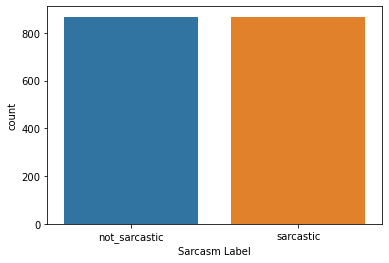

In [23]:
ax = sns.countplot(df_En.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
s_train = 0
ns_train = 0
for i in df_En.sarcastic:
    if i == 1:
        s_train+=1
    else:
        ns_train+=1
l_count = len(df_En.sarcastic)
print("train total", l_count, "sarcastic", s_train, "non sarcastic", ns_train)

In [24]:
df_Cn

,sarcastic,tweet
0,0,大国重器蓝色力量！
1,1,东野圭吾！你的白夜行可以再灰色一点没关系... \n
2,0,机不可失，失不再来，符合条件的朋友们，冲鸭！
3,1,我妈最常说的一句话：你脾气那么坏，谁敢娶你...(很好 )\n
4,1,近日，几十位资深专家经过连续多日反复论证研究得出观点：那些把共享单车又是投河又是破坏的人情有...
...,...,...
1995,1,马克龙虽出生在法国，但既然姓马，就可以得知他的祖先是中国人。而既然是中国人，名字却叫克龙，他...
1996,0,正在直播：失事飞机第二部黑匣子已找到 报社记者直击搜寻现场。记者27日从“3·21”东航MU...
1997,1,【谁说传销一无是处？年轻人入传销组织或可根治社恐症】 ​​​
1998,0,1个简单动作缓解腰部酸痛。久坐或长时间劳动后有肌肉僵硬、酸痛的感觉？试试这个动作，帮你缓解腰...


In [25]:
df_Cn_sar=df_Cn.loc[df_Cn['sarcastic'] == 1]
df_Cn_nsar=df_Cn.loc[df_Cn['sarcastic'] == 0]
df_Cn = pd.concat((df_Cn_sar[:500], df_Cn_nsar[:500]), join='outer')
df_Cn =df_Cn.reset_index(drop=True)
df_Cn

,sarcastic,tweet
0,1,东野圭吾！你的白夜行可以再灰色一点没关系... \n
1,1,我妈最常说的一句话：你脾气那么坏，谁敢娶你...(很好 )\n
2,1,近日，几十位资深专家经过连续多日反复论证研究得出观点：那些把共享单车又是投河又是破坏的人情有...
3,1,火大：你的声音真的可以再大声一点，可以再故意用力一点。 真的是会被你的声音活活给吓死~\n
4,1,昨日因吸毒被抓的几位迷笛音乐学校的学生面对媒体时吐露，他们是因为偶像尹相杰才走上音乐的道路，...
...,...,...
995,0,学校里的安全教育还是很有效的。
996,0,俄罗斯超伊朗成被美制裁最多国家，赵立坚称战争和制裁让美国赚得钵满盆满。4月6日，外交部例行记...
997,0,数据网站：2022年前三月美国逾万人死于枪支暴力。美国非营利组织“枪支暴力档案”网站30日最...
998,0,北京警方查控逃避防疫检查进京人员223人。记者26日从北京市公安局了解到，北京警方近期严打逃...


train total 1000 sarcastic 500 non sarcastic 500


/home/yang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


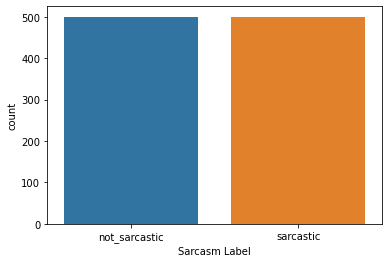

In [26]:

ax = sns.countplot(df_Cn.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
cs_train = 0
ncs_train = 0
for i in df_Cn.sarcastic:
    if i == 1:
        cs_train+=1
    else:
        ncs_train+=1
l_count = len(df_Cn.sarcastic)
print("train total", l_count, "sarcastic", cs_train, "non sarcastic", ncs_train)

In [27]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, normalization=True)

In [29]:
MAX_LEN = 100

In [30]:
class TweetDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet, add_special_tokens=True, max_length=self.max_len, 
            return_token_type_ids=False, pad_to_max_length=True,
            return_attention_mask=True, return_tensors='pt',
        )
        return {
            'tweet_text':tweet,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'targets':torch.tensor(target, dtype=torch.long)
        }

In [31]:
df_En

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
1729,i just overheard this bunch of children behind...,0
1730,started telling my dutch friends about how i'v...,0
1731,took my dog to the vet today because i thought...,0
1732,have to somehow become fluent in Spanish in th...,0


In [39]:

df_total=df_En
df_total = df_total.dropna(subset=['tweet'])
df_total =df_total.dropna(axis=1,how='any')
df_total =df_total.reset_index(drop=True)
df_total

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
1728,i just overheard this bunch of children behind...,0
1729,started telling my dutch friends about how i'v...,0
1730,took my dog to the vet today because i thought...,0
1731,have to somehow become fluent in Spanish in th...,0


In [41]:
import re
def clearTextFunc(text):
    clear_text= " ".join(text.split())
    clear_text=re.sub(r'http://[a-zA-Z0-9.?/&=:]*'," ", clear_text) #去除URL
    clear_text=re.sub(r'https://[a-zA-Z0-9.?/&=:]*'," ", clear_text) #去除URL
    clear_text=re.sub(r'@[a-zA-Z0-9.?/&=:]*'," ", clear_text)#去除@
    clear_text=re.sub(r'/s'," ",clear_text)
    clear_text=re.sub(r'/j'," ",clear_text)

    return clear_text

In [42]:
df_total['tweet']=df_total['tweet'].apply(clearTextFunc)
df_total

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,"I did too, and I also reported Cancun Cr...",1
...,...,...
1728,i just overheard this bunch of children behind...,0
1729,started telling my dutch friends about how i'v...,0
1730,took my dog to the vet today because i thought...,0
1731,have to somehow become fluent in Spanish in th...,0


train total 1733 sarcastic 867 non sarcastic 866


/home/yang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


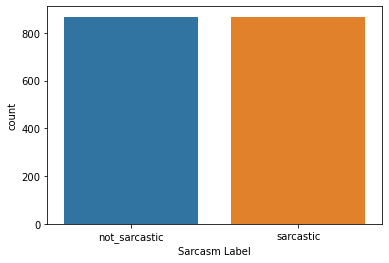

In [43]:
ax = sns.countplot(df_total.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
ts_train = 0
tns_train = 0
for i in df_total.sarcastic:
    if i == 1:
        ts_train+=1
    else:
        tns_train+=1
l_count = len(df_total.sarcastic)
print("train total", l_count, "sarcastic", ts_train, "non sarcastic", tns_train)

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
for train_index, text_index in split.split(df_total, df_total['sarcastic']):
    df_train = df_total.loc[train_index]
    df_val = df_total.loc[text_index]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
    

In [45]:
df_train

,tweet,sarcastic
0,everyone say a prayer to the insurance gods th...,1
1,Having my first experience of a Whetherspoon h...,0
2,Who likes cats?? These handmade cushions are p...,0
3,"Well done Henri, cost us the win #nffc",1
4,have to somehow become fluent in Spanish in th...,0
...,...,...
1208,Join me on to help save our planet in just 2...,0
1209,Wishing all the birthday sex on today 🎂,1
1210,Beautician and the Beast (1997). Best Timothy ...,1
1211,cold weather please hurry i want to wear sweat...,0


In [46]:
df_val

,tweet,sarcastic
0,Totall Carloss... #WTF1 _aarava,0
1,I think the episode really fails cos of th...,0
2,am honestly so disturbed by the star signs cha...,0
3,rom coms from the 2000s are simply built diffe...,0
4,Las Iguanas 👌😍🍷🍴,0
...,...,...
515,I love how men know they have a baby on the wa...,1
516,I’m going back to work exactly 8 weeks postpar...,0
517,"Let me guess, it has to be Charlotte Tilbury m...",1
518,Fun fact: I sing I Morgan ar en annan dag to m...,0


In [47]:
df_train.shape

(1213, 2)

In [48]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        tweets=df.tweet.to_numpy(),
        targets=df.sarcastic.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [49]:
BATCH_SIZE=16
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [50]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [51]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [53]:
class SarcasmClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SarcasmClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.embed_size = self.bert.config.hidden_size
        self.label_num = n_classes
        self.fc_dropout = 0.2
        self.hidden_num = 1
        self.hidden_size = 256
        self.hidden_dropout = 0.5
        self.bidirectional = True
        self.pad_size=32
        

        
        self.lstm = nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.hidden_num,
            bidirectional=True,
            #dropout=self.hidden_dropout,
            batch_first=True
        )
        self.maxpool = nn.MaxPool1d(self.pad_size)

        self.dropout=nn.Dropout(self.hidden_dropout)
        self.fc_dropout = nn.Dropout(self.fc_dropout)
        self.linear1 = nn.Linear(self.hidden_size *2, self.hidden_size//2)
        self.linear2 = nn.Linear(self.hidden_size//2, self.label_num)
        

    def forward(self, input_ids, attention_mask):
        #sequence_output size: (batch_size, sequence_length, 768)
        sequence_output, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        lstm_out,(hidden_last,cn_last) = self.lstm(sequence_output)
        #hidden = torch.cat((lstm_out[:,-1,:256], lstm_out[:,0,256:]), dim=-1)
        #hidden = hidden.view(-1,256*2)
        
        if self.bidirectional:
            hidden_last_L= hidden_last[-2]
            hidden_last_R = hidden_last[-1]
            hidden = torch.cat([hidden_last_L, hidden_last_R],dim=-1)
        else:
            hidden=hidden_last[-1]
        out=self.dropout(hidden)
       # out = hidden.permute(0, 2, 1)
       # out = self.maxpool(out).squeeze()
        out = F.relu(self.linear1(hidden))
        out = self.fc_dropout(out)
        output = self.linear2(out)

        return output
        

        

In [54]:
class SarcasmClassifier_Ori(nn.Module):
    def __init__(self, n_classes):
        super(SarcasmClassifier_Ori, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask, return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [55]:
model = SarcasmClassifier(len(class_names))
#model = SarcasmClassifier_Ori(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
for name, parameters in model.named_parameters():
    print(name,':',parameters.size())

bert.embeddings.word_embeddings.weight : torch.Size([119547, 768])
bert.embeddings.position_embeddings.weight : torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight : torch.Size([2, 768])
bert.embeddings.LayerNorm.weight : torch.Size([768])
bert.embeddings.LayerNorm.bias : torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias : torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias : torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias : torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias : torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight : torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias :

In [57]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


In [58]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [59]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=4e-6, correct_bias=False)
total_steps = len(train_data_loader)*EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/yang/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [60]:
def train_epoch(
    model, data_loader, loss_fn, optimizer, device, scheduler, n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss=loss_fn(outputs, targets)
        correct_predictions +=torch.sum(preds==targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
   
    return correct_predictions.double()/n_examples, np.mean(losses)
    

In [61]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses=[]
    correct_predictions=0
    with torch.no_grad():
        for d in data_loader:
            input_ids=d['input_ids'].to(device)
            attention_mask=d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)

In [62]:
from collections import defaultdict



history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*10)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc>best_accuracy:
        best_accuracy = val_acc
 

Epoch 1/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.6940916862926985 accuracy 0.494641384995878


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.6940819729458202 accuracy 0.5

Epoch 2/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Train loss 0.6882078490759197 accuracy 0.5457543281121188


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.6930876916105096 accuracy 0.5076923076923077

Epoch 3/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.652655207012829 accuracy 0.651277823577906


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.6844371105685378 accuracy 0.5673076923076923

Epoch 4/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.5797409815223593 accuracy 0.7452596867271228


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.6905917218237212 accuracy 0.5942307692307692

Epoch 5/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.5055749251654273 accuracy 0.8145094806265458


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.7090212034456658 accuracy 0.5903846153846154

Epoch 6/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Train loss 0.438326091750672 accuracy 0.8499587798845837


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Val loss 0.7343038157983259 accuracy 0.5865384615384616

Epoch 7/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.3899988471285293 accuracy 0.8812860676009893


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.7630673430182717 accuracy 0.5826923076923077

Epoch 8/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.356558465447865 accuracy 0.8936521022258862


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.7908184284513647 accuracy 0.5730769230769232

Epoch 9/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Train loss 0.3282697865445363 accuracy 0.9150865622423743


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Val loss 0.8157469512838306 accuracy 0.5692307692307692

Epoch 10/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.30883484294540003 accuracy 0.9241549876339654


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.8348478223338271 accuracy 0.5750000000000001



# Test

In [63]:
df_En_test = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/TaskA_Test.csv")
df_test = df_En_test.dropna(subset=['tweet','sarcastic'])
df_test =df_test.dropna(axis=1,how='any')
df_test =df_test.reset_index(drop=True)
df_test['tweet']=df_test['tweet'].apply(clearTextFunc)
df_test

,tweet,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men :pleading_face:,0
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,0
1396,Omg how an earth is that a pen !! :clown_face:,0
1397,Bringing Kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...",1


In [ ]:
df_HL_test = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/Sarcasm_Headlines_Dataset_v2.csv")
df_HL_test = df_HL_test.drop('article_link',axis=1)
df_HL_test = df_HL_test.rename(columns={'is_sarcastic':'sarcastic', 'headline':'tweet'})

df_HL_test['tweet']=df_HL_test['tweet'].apply(clearTextFunc)
df_test=df_HL_test


In [64]:
test_data_loader=create_data_loader(df_test, tokenizer,MAX_LEN,BATCH_SIZE)

In [65]:
test_acc,_ = eval_model(
    model, test_data_loader, loss_fn, device, len(df_test)
)
test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

0.44357142857142856

In [66]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweet_texts=[]
    predictions=[]
    prediction_probs=[]
    real_values=[]
    with torch.no_grad():
        for d in data_loader:
            texts=d['tweet_text']
            input_ids=d['input_ids'].to(device)
            attention_mask=d['attention_mask'].to(device)
            targets=d['targets'].to(device)

            outputs=model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds=torch.max(outputs,dim=1)
            probs = F.softmax(outputs,dim=1)
            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions=torch.stack(predictions).cpu()
    prediction_probs=torch.stack(prediction_probs).cpu()
    real_values=torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [67]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model, val_data_loader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

In [68]:
print(classification_report(y_test, y_pred,target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.5980    0.4577    0.5185       260
    sarcastic     0.5607    0.6923    0.6196       260

     accuracy                         0.5750       520
    macro avg     0.5794    0.5750    0.5691       520
 weighted avg     0.5794    0.5750    0.5691       520



In [69]:
y_tweet_texts, y_pred, y_pred_probs,y_test = get_predictions(
    model, test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

In [70]:
print(classification_report(y_test,y_pred,target_names=class_names,digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.8920    0.3992    0.5515      1200
    sarcastic     0.1645    0.7100    0.2672       200

     accuracy                         0.4436      1400
    macro avg     0.5283    0.5546    0.4093      1400
 weighted avg     0.7881    0.4436    0.5109      1400

